In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# 1. Data Preparation

In [4]:
#Load the dataset and inspect its structure.

df = pd.read_csv ('ecommerce_customer_data_large.csv')

In [5]:
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [6]:
df.shape

(250000, 13)

In [7]:
#Handle missing values, duplicate rows, and data inconsistencies.
df.isnull().sum()

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64

In [8]:
df ['Returns'] = df ['Returns'].fillna (0)

In [9]:
df.duplicated ().sum ()

0

In [10]:
#Convert date-related fields into a suitable datetime format, if applicable.
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
df['Returns'] = df['Returns'].astype(int)
df = df.drop('Age', axis=1)
df ['Customer ID'] = df ['Customer ID'].astype (object)
df['Returns'] = df['Returns'].astype(bool)
df['Churn'] = df ['Churn'].astype(bool)

In [11]:
#Perform feature engineering to create meaningful columns such as: TotalPurchase (e.g., Quantity × Unit Price).
df ['TotalPurchase'] = df['Quantity'] * df['Product Price']
df = df.drop('Total Purchase Amount', axis=1)

# 2. K-Means Clustering

In [13]:
# Group by customer to create summary features
customer_df = df.groupby('Customer ID').agg({
    'TotalPurchase': ['sum', 'count']
}).reset_index()

In [14]:
customer_df

Customer ID TotalPurchase      
                            sum count
0               1          5600     3
1               2          6459     6
2               3          3613     4
3               4          4339     5
4               5          2263     5
...           ...           ...   ...
49656       49996          6107     7
49657       49997          1592     2
49658       49998          8440    10
49659       49999          4188     6
49660       50000          3871     7

[49661 rows x 3 columns]

In [15]:
customer_df.columns = ['Customer ID','TotalSales', 'OrderCount']
customer_df['AvgOrderValue'] = customer_df ['TotalSales']/customer_df ['OrderCount']

In [16]:
customer_df

,Customer ID,TotalSales,OrderCount,AvgOrderValue
0,1,5600,3,1866.666667
1,2,6459,6,1076.500000
2,3,3613,4,903.250000
3,4,4339,5,867.800000
4,5,2263,5,452.600000
...,...,...,...,...
49656,49996,6107,7,872.428571
49657,49997,1592,2,796.000000
49658,49998,8440,10,844.000000
49659,49999,4188,6,698.000000


In [17]:
#Standardize the dataset for clustering by normalizing the numeric columns (e.g., using Min-Max scaling).
numeric_columns = ['TotalSales', 'OrderCount', 'AvgOrderValue']

numeric_columns

['TotalSales', 'OrderCount', 'AvgOrderValue']

In [18]:
# Apply Min-Max Scaling
scaler = MinMaxScaler()
customer_df[numeric_columns] = customer_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
customer_df[numeric_columns] = scaler.fit_transform(customer_df[numeric_columns])

In [19]:
normalized_df = customer_df[numeric_columns]
normalized_df

,TotalSales,OrderCount,AvgOrderValue
0,0.320525,0.1250,0.745547
1,0.369788,0.3125,0.428084
2,0.206572,0.1875,0.358477
3,0.248208,0.2500,0.344235
4,0.129151,0.2500,0.177421
...,...,...,...
49656,0.349601,0.3750,0.346094
49657,0.090669,0.0625,0.315388
49658,0.483397,0.5625,0.334673
49659,0.239548,0.3125,0.276014


In [20]:
# Selecting the best numbers for clusters

from sklearn.metrics import silhouette_score

for n_cluster in [2,3,4,5]:
    kmeans = KMeans(n_clusters=n_cluster).fit(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']]
    )
    silhouette_avg = silhouette_score(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']],
        kmeans.labels_
    )

    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 2 Clusters: 0.3812
Silhouette Score for 3 Clusters: 0.3489
Silhouette Score for 4 Clusters: 0.3487
Silhouette Score for 5 Clusters: 0.3485


#### Since the 2 Clusters score has the highest Silhouette score, 2 would be used as clustering number for this project.

In [22]:
# Select features for clustering and Initialize and fit KMeans with a fixed random state
kmeans = KMeans(n_clusters=2, random_state=42)

cluster_labels = kmeans.fit_predict(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])

#Create a new DataFrame to store clustering results
two_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)

two_cluster_df['Cluster'] = cluster_labels

In [23]:
two_cluster_df.head(5)

,TotalSales,OrderCount,AvgOrderValue,Cluster
0,0.320525,0.1250,0.745547,1
1,0.369788,0.3125,0.428084,1
2,0.206572,0.1875,0.358477,0
3,0.248208,0.2500,0.344235,1
4,0.129151,0.2500,0.177421,0


In [24]:
two_cluster_df.groupby('Cluster').count()['TotalSales']


Cluster
0    28974
1    20687
Name: TotalSales, dtype: int64

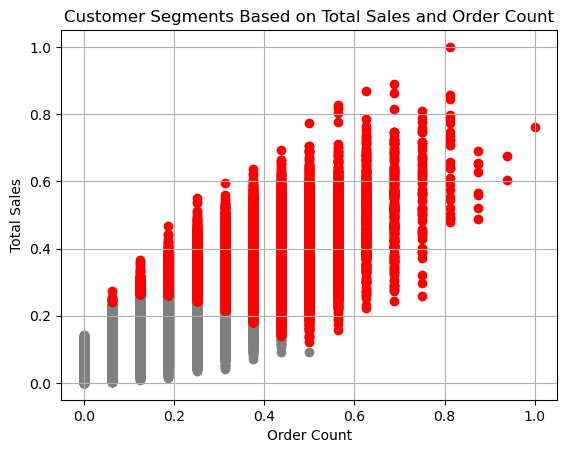

In [25]:
plt.scatter(
    two_cluster_df.loc[two_cluster_df['Cluster'] == 0]['OrderCount'],
    two_cluster_df.loc[two_cluster_df['Cluster'] == 0]['TotalSales'],
    c='grey'
)

plt.scatter(
    two_cluster_df.loc[two_cluster_df['Cluster'] == 1]['OrderCount'],
    two_cluster_df.loc[two_cluster_df['Cluster'] == 1]['TotalSales'],
    c='red'
)

plt.title('Customer Segments Based on Total Sales and Order Count')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid()
plt.show()

### Analysis

1. The Cluster 0 (Grey) means low order count and low total sales.
   These are low-value customers who purchase infrequently and spend less overall.

2. TheCluster 1 (Red) means higher order count and higher total sales.
   These are high-value customers who buy often and generate the most revenue.They are your most profitable segment.
3. This clustering is financially driven, showing the direct contribution of customers to your revenue. It helps you prioritize retention of top-tier customers and strategize how to nurture lower-tier customers.

Recommendation : It is great for business and revenue-focused segmentation (e.g., targeting top 20% of customers driving 80% of sales).

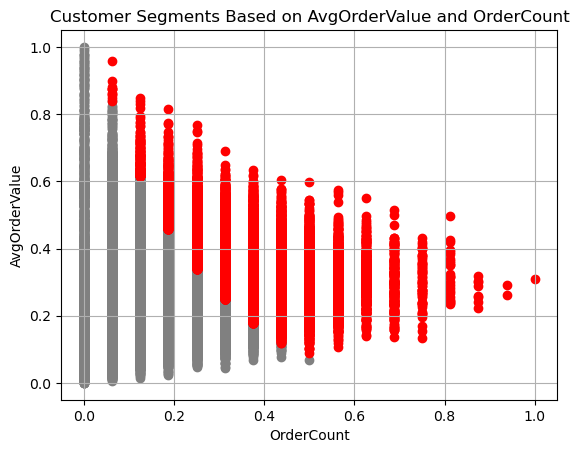

In [27]:
plt.scatter(
    two_cluster_df.loc[two_cluster_df['Cluster'] == 0]['OrderCount'],
    two_cluster_df.loc[two_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='grey'
)

plt.scatter(
    two_cluster_df.loc[two_cluster_df['Cluster'] == 1]['OrderCount'],
    two_cluster_df.loc[two_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red'
)

plt.title('Customer Segments Based on AvgOrderValue and OrderCount')
plt.xlabel('OrderCount')
plt.ylabel('AvgOrderValue')

plt.grid()
plt.show()

### Analysis

1. Cluster 0 (Grey) means low order count, high average order value. They are likely infrequent big spenders or premium customers.
    These customers could be targeted with loyalty programs or premium services.

2. Cluster 1 (Red) means higher order count, lower average order value. They are likely frequent low spenders. It could be ideal for volume-based promotions or bundled discounts.

3. This clustering reveals two distinct behavioral segments: Quality-focused customers (spend more per order) and Quantity-focused customers (order more often but spend less per order).

Recommendation: It is great for segmenting marketing strategies based on behavior rather than just revenue.

# Pareto Analysis

In [30]:
pareto_df = customer_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
pareto_df['Cluster'] = kmeans.labels_

In [31]:
pareto_df = pareto_df[['TotalSales', 'Cluster']]
pareto_df

,TotalSales,Cluster
0,0.320525,1
1,0.369788,1
2,0.206572,0
3,0.248208,1
4,0.129151,0
...,...,...
49656,0.349601,1
49657,0.090669,0
49658,0.483397,1
49659,0.239548,1


In [32]:
pareto_df = pareto_df.groupby('Cluster')['TotalSales'].sum().reset_index()
pareto_df

,Cluster,TotalSales
0,0,4019.580604
1,1,6930.834834


In [33]:
# Sort data by total sales in descending order
pareto_df = pareto_df.sort_values(by='TotalSales', ascending=False)

pareto_df

,Cluster,TotalSales
1,1,6930.834834
0,0,4019.580604


In [34]:
# Calculate cumulative percentage
pareto_df['Cumulative Percentage'] = pareto_df['TotalSales'].cumsum() / pareto_df['TotalSales'].sum() * 100

pareto_df

,Cluster,TotalSales,Cumulative Percentage
1,1,6930.834834,63.292894
0,0,4019.580604,100.000000


In [35]:
pareto_df['Cluster'] = pareto_df['Cluster'].astype(str)

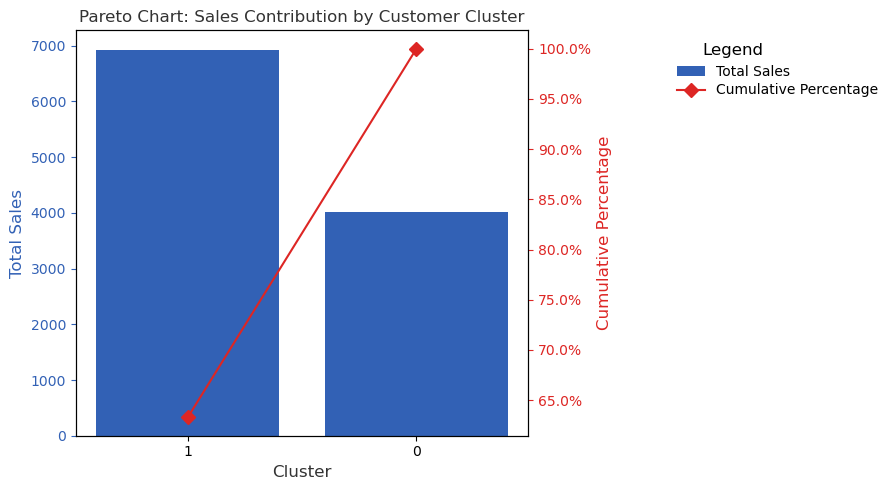

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Specify the width and height (in inches) using figsize
fig, ax = plt.subplots(figsize=(10,5))

# Use dark blue for the bars and dark orange for the line
ax.bar(pareto_df["Cluster"], pareto_df["TotalSales"], color="#3261B5")  # Dark blue
ax2 = ax.twinx()
ax2.plot(pareto_df["Cluster"], pareto_df["Cumulative Percentage"], color="#DD2624", marker="D", ms=7)  # Dark orange

# Format the y-axis on the right to show percentage
ax2.yaxis.set_major_formatter(PercentFormatter())

# Set tick colors
ax.tick_params(axis="y", colors="#3261B5")  # Matching the bar color
ax2.tick_params(axis="y", colors="#DD2624")  # Matching the line color

# Add labels and title
ax.set_xlabel('Cluster', fontsize=12, color="#333333")
ax.set_ylabel('Total Sales', fontsize=12, color="#3261B5")
ax2.set_ylabel('Cumulative Percentage', fontsize=12, color="#DD2624")
plt.title('Pareto Chart: Sales Contribution by Customer Cluster', fontsize=12, color="#333333")

# Add legends with adjusted position
ax.legend(["Total Sales"], loc='upper left', fontsize=10, frameon=False, title="Legend", title_fontsize=12, bbox_to_anchor=(1.3, 1))
ax2.legend(["Cumulative Percentage"], loc='upper left', fontsize=10, frameon=False, bbox_to_anchor=(1.3, 0.9))

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

### Analysis for Pareto Chart

1. The Cluster 0 contributes the highest total sales, around 7000+ units.
    According to the cumulative percentage line (in red), this group contributes roughly 65–70% of total sales alone.
2. The cluster 1 contributes significantly less than Cluster 1, around 4000 units.
3. Cluster 0 is your most valuable segment in terms of revenue generation.These customers are likely frequent buyers or high-spenders.
4. Cluster 1 contributes less and may need nurturing, or they could represent occasional buyer and budget-conscious customers.
5. We can prioritize retention campaigns and exclusive offers for the cluster 0 customers.